# Análisis de Redes Sociales, Práctica I
Paula Corral rebollar y Lucía Cuevas Serrano

# Datos

## Cargar datos

Cargamos los datos directamente del archivo en github y lo abrimos como un grafo usando NetworkX.

In [1]:
import requests
import networkx as nx
from io import BytesIO

# Descargar archivo
response = requests.get("https://raw.githubusercontent.com/luciacuevascsv/analisis_redes_sociales/main/Practica%20I/hashtags_cleaned.graphml")
response.raise_for_status()

# Cargar grafo
file_like = BytesIO(response.content)
G = nx.read_graphml(file_like)
print("Número de nodos:", G.number_of_nodes())
print("Número de aristas:", G.number_of_edges())


Número de nodos: 47544
Número de aristas: 536124


## Visualizar datos

Seguimos los resultados mostrados en [Campaign 2020 on Twitter: Top Names and Hashtags by Mention Volume de The George Washington University](https://gspm.gwu.edu/sites/g/files/zaxdzs5061/files/downloads/Campaign%202020%20on%20Twitter.pdf) mostrados a continuación para ver subgrafos basados en hashtags populares de ambos partidos (Republicano en la primera fila y Demócrata en la segunda).

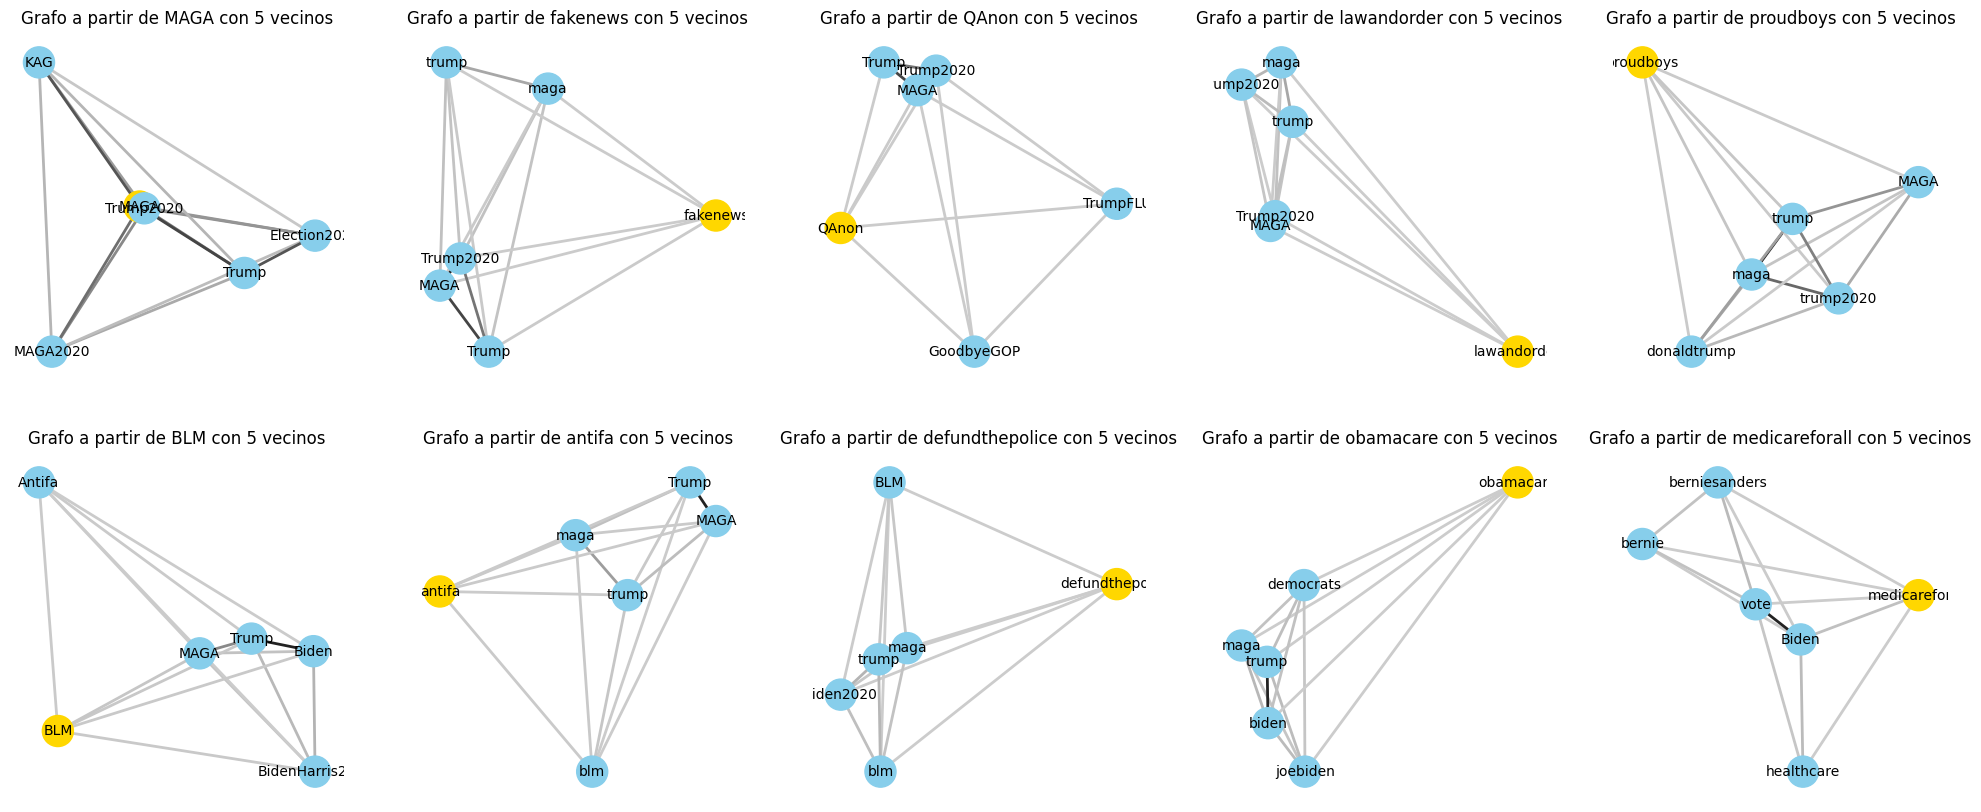

In [2]:
import matplotlib.pyplot as plt

def demo_nodos(central_node, number_neighbors):

    # Ordenar vecinos
    neighbors = list(G[central_node].items())
    neighbors_sorted = sorted(neighbors, key=lambda x: float(x[1].get("weight",0)), reverse=True)
    top5_neighbors = [n for n, attr in neighbors_sorted[:number_neighbors]]

    # Crear subgrafo
    sub_nodes = [central_node] + top5_neighbors
    subG = G.subgraph(sub_nodes)

    # Dibujar nodos
    pos = nx.spring_layout(subG, seed=42)
    node_colors = ["gold" if n == central_node else "skyblue" for n in subG.nodes()]
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=500)

    # Colores de las aristas
    min_gray = "#cccccc"  
    max_gray = "#222222"  
    def hex_to_rgb(h):
        h = h.lstrip("#")
        return tuple(int(h[i:i+2],16)/255 for i in (0,2,4))

    rgb_min = hex_to_rgb(min_gray)
    rgb_max = hex_to_rgb(max_gray)

    weights = [float(subG[u][v].get("weight",1)) for u,v in subG.edges()]
    max_weight = max(weights)

    edge_colors = []
    for w in weights:
        t = w / max_weight  
        r = rgb_min[0] + t*(rgb_max[0]-rgb_min[0])
        g = rgb_min[1] + t*(rgb_max[1]-rgb_min[1])
        b = rgb_min[2] + t*(rgb_max[2]-rgb_min[2])
        edge_colors.append((r,g,b))

    # Dibujar aristas
    nx.draw_networkx_edges(subG, pos, width=2, edge_color=edge_colors)

    # Etiquetas
    nx.draw_networkx_labels(subG, pos, font_size=10)

    plt.title(f"Grafo a partir de {central_node} con {number_neighbors} vecinos")
    plt.axis('off')

hashtags = [
    "MAGA", "fakenews", "QAnon", "lawandorder", "proudboys",
    "BLM", "antifa", "defundthepolice", "obamacare", "medicareforall"
]

fig, axes = plt.subplots(2,5, figsize=(25,10))  

for ax, hashtag in zip(axes.flatten(), hashtags):
    plt.sca(ax) 
    demo_nodos(hashtag, 5)  


# Ejercicios

## 1. Calcula las comunidades utilizando el algoritmo de Leiden. ¿Cuántas comunidades salen? 

In [3]:
!pip install cdlib
!pip install leidenalg

In [4]:
from cdlib.algorithms import leiden

communities = leiden(G)

num_communities = len(communities.communities)
print("Número de comunidades detectadas:", num_communities)


Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'infomap', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap'}
Número de comunidades detectadas: 46


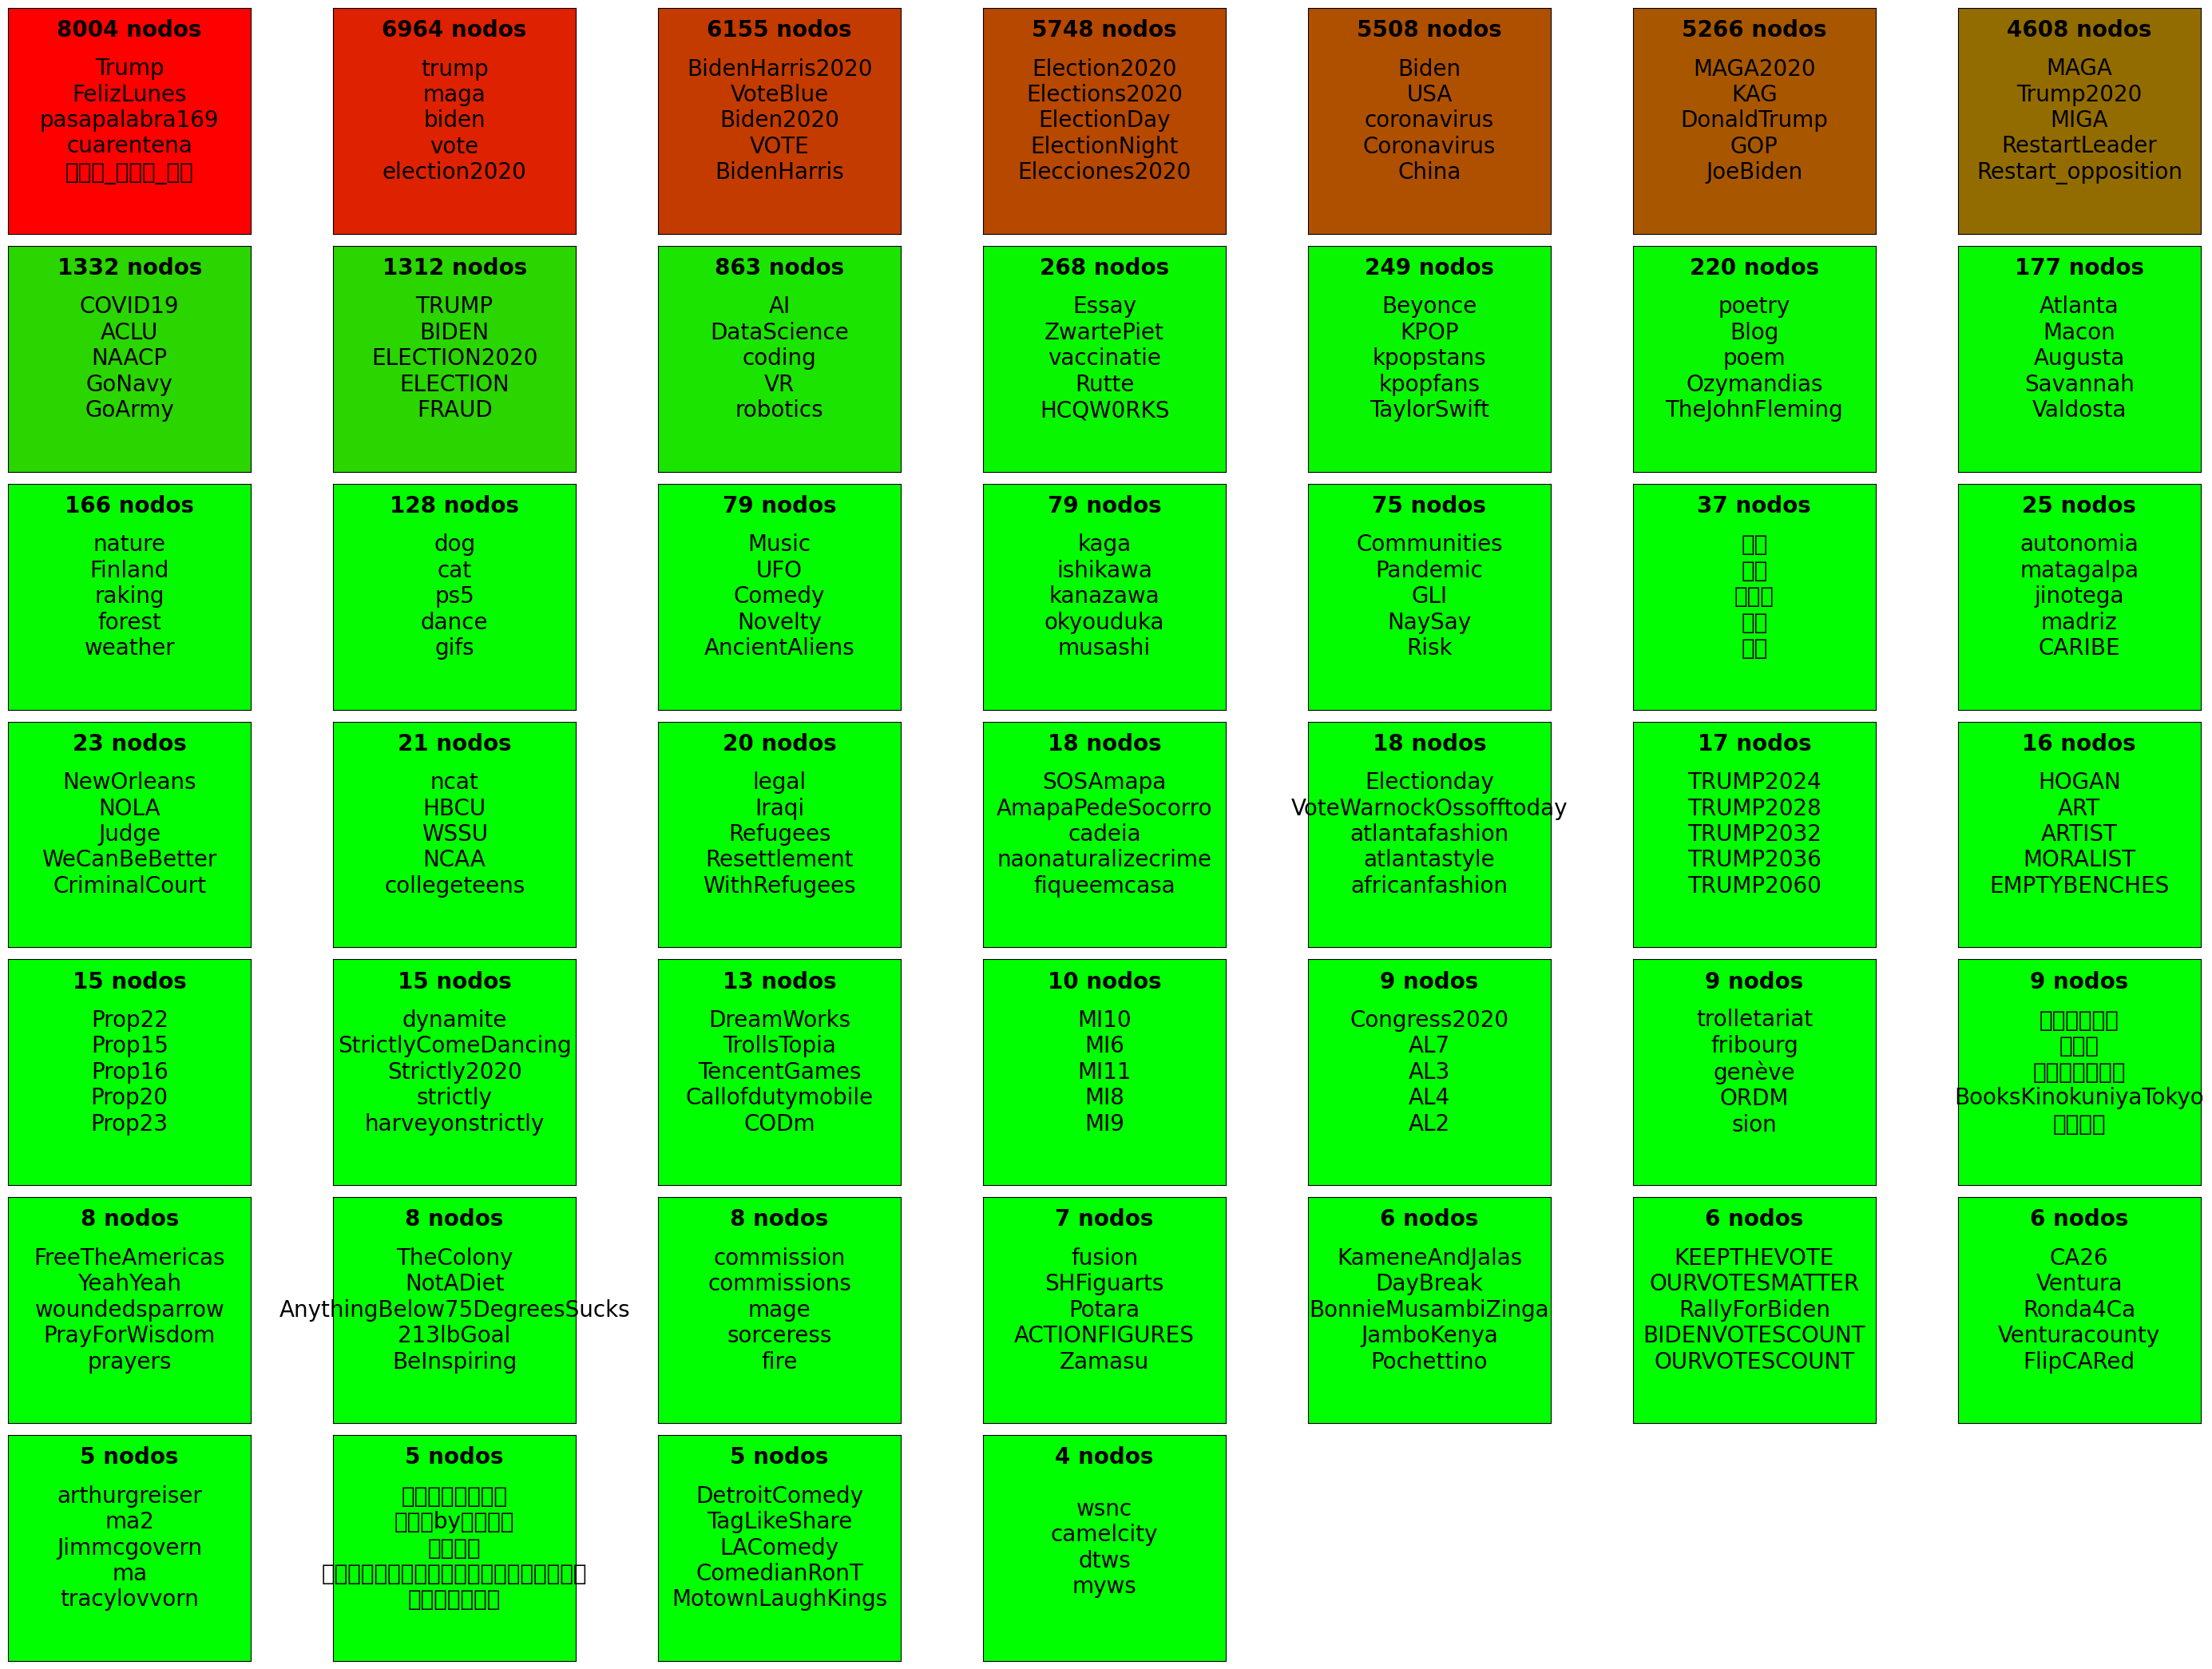

In [5]:
import numpy as np
plt.rcParams['font.family'] = 'DejaVu Sans'

# Calcular nodos más importantes (mayor weight total) de cada comunidad
community_sizes = [len(com) for com in communities.communities]
top_nodes = []
for com in communities.communities:
    subG = G.subgraph(com)
    node_weights = {n: sum(float(subG[n][nbr].get("weight",1)) for nbr in subG[n]) for n in subG.nodes()}
    top5 = sorted(node_weights, key=node_weights.get, reverse=True)[:5]
    top_nodes.append(top5)

# Figura
cols = 7
rows = int(np.ceil(len(communities.communities) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
min_size, max_size = min(community_sizes), max(community_sizes)

for i, ax in enumerate(axes.flatten()):
    if i >= len(communities.communities):
        ax.axis("off")
        continue
    
    # Color según tamaño de la comunidad
    size = community_sizes[i]
    t = (size - min_size) / (max_size - min_size + 1e-6)
    color = (t, 1-t, 0)
    
    ax.add_patch(plt.Rectangle((0,0),1,1,color=color))
    
    # Escribir top 5 nodos
    text = "\n".join(top_nodes[i])
    ax.text(0.5, 0.5, text, ha="center", va="center", fontsize=20)
    ax.text(0.5, 0.95, f"{size} nodos", ha="center", va="top", fontsize=20, fontweight='bold')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

plt.tight_layout()
plt.show()


## 2. Utiliza Weisfeiler-lehmangraph kernels para codificar cada una de las comunidades como si de grafos independientes se trataran. Basado en los resultados obtenidos, ¿qué comunidades son más similares? 


In [6]:
!pip install grakel

In [7]:
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, VertexHistogram

# Convertir cada comunidad en un grafo independiente
grakel_graphs = graph_from_networkx([G.subgraph(c).copy() for c in communities.communities], val_node_labels='0')

# Crear el kernel WL
wl = WeisfeilerLehman(n_iter=3, normalize=True, base_graph_kernel=VertexHistogram)
K = wl.fit_transform(grakel_graphs)

# Ignorar la diagonal (auto-similitud)
K_no_diag = K.copy()
np.fill_diagonal(K_no_diag, 0)

# Encontrar las 3 parejas más similares
indices = np.unravel_index(np.argsort(K_no_diag, axis=None)[-3:], K_no_diag.shape)
similarities = K_no_diag[indices]

for idx in range(3):
    i = indices[0][idx]
    j = indices[1][idx]
    print(f"Pareja de comunidades más similares {idx+1}: Comunidad {i} y Comunidad {j} - Similitud: {similarities[idx]:.4f}")


ImportError: cannot import name 'ComplexWarning' from 'numpy' (/usr/local/lib/python3.12/dist-packages/numpy/__init__.py)

## 3. El tamaño del grafo excede el tiempo que tenemos en la práctica, por ello, y para tener una representación más compacta, colapsa el grafo de forma que cada nodo sea una comunidad, manteniendo los atributos. 


## 4. Aplica distintas métricas que puedan resultar útiles para tener una mejor idea de las comunidades, y crea visualizaciones diferentes en función de las métricas. 

## 5. ¿Hay nodos centrales?, ¿qué métricas nos ayudan a saberlo? ¿Qué métricas macro nos servirían para explicar la estructura de la red, teniendo en cuenta que son comunidades y no nodos? 


## 6. ¿Merece la pena hacer comunidades solapadas o no solapadas?

## 7. ¿Si visualizamos la/s comunidad/es más grandes y las más pequeñas; que se ve, que nos dice esa representación? 

## 8. Describe los contenidos de cada comunidad. ¿Es posible, aunque sea intuitivamente, caracterizar una comunidad en función de sus hashtags más importantes? 


## 9. Finalmente, utilizando técnicas de predicción de aristas, ¿qué comunidades tienen más probabilidades de estar unidas? Habiendo descrito dichas comunidades previamente, ¿tienen sentido estas predicciones? 
